In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from tqdm import tqdm

In [118]:
se_label = 'Individual Side Effect'

# Drug-Target
df_dt = pd.read_csv('../data/bio-decagon-targets.csv').rename(columns={'STITCH': 'drug', 'Gene': 'gene'})
df_dt = df_dt.rename(columns={'drug': 'STITCH'})

# Drug-Side Effect
df_ds = pd.read_csv('../data/bio-decagon-mono.csv') # drug - side-effect


# Drug ID mapper
df = pd.read_csv('../data/drugbank.txt', sep='\t')
df = df.drop_duplicates(subset=['DrugbankID', 'CID'], keep='first')

did_to_cid = {row.DrugbankID: row.CID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}
cid_to_did = {row.CID: row.DrugbankID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}

df_ds['compound'] = df_ds.STITCH.apply(lambda x: cid_to_did.get(x, None))
df_dt['compound'] = df_dt.STITCH.apply(lambda x: cid_to_did.get(x, None))

all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
all_targets = list(set(df_dt.gene.tolist()))
n_drugs = len(all_drugs)
n_targets = len(all_targets)
pp_idx_mapper = {p: all_targets.index(p) for p in all_targets}
all_se = list(df_ds[se_label].unique())
all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))

se_idx_mapper = {se: i for i, se in enumerate(all_se)}
df_ds['se_idx'] = df_ds[se_label].apply(lambda x: se_idx_mapper[x])

# Drug Similarity
df_dsim = pd.read_csv('../data/similarity.csv', index_col=0)
df_dsim['STITCH0'] = df_dsim.compound0.apply(lambda x: did_to_cid.get(x, None))
df_dsim['STITCH1'] = df_dsim.compound1.apply(lambda x: did_to_cid.get(x, None))
print(df_ds.shape)

(174977, 5)


In [131]:
filtered_se = df_ds.groupby('Individual Side Effect').count()[
    df_ds.groupby('Individual Side Effect').count().STITCH>10].index.unique()#.unique()
df_ds = df_ds[df_ds[se_label].isin(filtered_se)]
df_ds.shape

(151856, 5)

In [133]:
df_ds[se_label].unique().shape

(3637,)

In [134]:
filtered_se.shape

(3637,)

In [135]:
from typing import Set

def jaccard(s1: Set, s2: Set):
    return len(s1.intersection(s2))/len((s1.union(s2)))

jaccard({1,2,3,4}, {1,2})

0.5

In [19]:
set(df_dt[df_dt.STITCH=='CID003062316'].gene.unique()).intersection(
    set(df_dt[df_dt.STITCH=='CID000005245'].gene.unique()))

set()

In [136]:
drugs = ['CID000003488', 'CID000003961']#, 'CID000005245', 'CID003062316']

In [137]:
df_dt_ft = df_dt[df_dt.STITCH.isin(drugs)]
df_ds_ft = df_ds[df_ds.STITCH.isin(drugs)]
df_ds_ft = df_ds_ft[df_ds_ft.se_idx%2==0]
df_ds_ft.shape

(203, 5)

In [141]:
df_ds.groupby(se_label).count()

,STITCH,Side Effect Name,compound,se_idx
Individual Side Effect,,,,
C0000727,45,45,24,45
C0000729,29,29,28,29
C0000733,12,12,6,12
C0000734,67,67,36,67
C0000735,36,36,19,36
...,...,...,...,...
C2979982,41,41,34,41
C2981158,22,22,19,22
C3203358,19,19,17,19


In [82]:
from scipy.linalg import fractional_matrix_power
class DSERandomWalk:
    
    def __init__(self, df_ds, df_dsim, df_dt, lmd=0.5, w_d=0.7):
        self.df_ds = df_ds
        self.df_dsim = df_dsim
        self.df_dt = df_dt
        all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
#         all_drugs = list(set(df_dsim['STITCH0'].unique()).union(set(df_dsim['STITCH1'].unique())))
#         self.all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
        self.all_targets = list(set(df_dt.gene.tolist()))
        self.n_drugs = len(all_drugs)
        self.n_targets = len(all_targets)
        all_se = list(df_ds[se_label].unique())
        all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))
        
        # side effect similarity
        S_s = self.ss_similarity_matrix(df=df_ds, all_se=all_se)
        S_d_t = self.dd_target_similarity_matrix(df_dt, all_drugs=all_drugs)
        S_d_c = self.dd_chem_similarity_matrix(all_drugs=all_drugs, df_sim=df_dsim)
        S_d = w_d*S_d_c + (1-w_d)*S_d_t

        A_ds = self.ds_adj_matrix(df_ds, all_se, all_drugs)
    
        self.M_ss = self.ss_transition_matrix(S_s, A_ds, lmd=lmd)
        self.M_sd = self.sd_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds)
        self.M_ds = self.ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds)
        self.M_dd = self.dd_transition_matrix(S_d, A_ds, lmd=0.5)
        
        
    def ds_adj_matrix(cls, df, all_se, all_drugs): 
        """Drug-Side Effect Adjacency Matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se) 
        A = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            nbrs = df[df.STITCH==all_drugs[i]].se_idx.unique()
            nbrs = df[df.STITCH==all_drugs[i]][se_label]
            nbrs = [all_se.index(nb) for nb in nbrs]
            for j in nbrs:
                A[i, j] = 1
        return A   
    
    def dd_chem_similarity_matrix(cls, all_drugs, df_sim):
        """Drug-Drug similarity matrix based on chemical structures"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            poi = df_sim[(df_sim.STITCH0==d1)|(df_sim.STITCH1==d1)]
            if not poi.shape[0]:
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                ss = poi[(poi.STITCH0==d2)|(poi.STITCH1==d2)]
                if ss.shape[0]:
                    s = ss.iloc[0].similarity
                    M[i, j] = s
                    M[j, i] = s

        # normalize
        norm_terms = np.sum(M, axis=1)
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)

        return S

    def dd_target_similarity_matrix(cls, df_dt, all_drugs):
        """Drug-Drug similarity based on shared targets"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            targets_i = set(df_dt[df_dt.STITCH==d1].gene)
            if not len(targets_i):
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                targets_j = set(df_dt[df_dt.STITCH==d2].gene)
                if not len(targets_i):
                    continue
                jc = jaccard(targets_i, targets_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
        
    def ss_similarity_matrix(cls, df, all_se):
        """Side Effect-Side Effect similarity based on shared drugs"""
        n = len(all_se)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            se1 = all_se[i]
            drugs_i = set(df[df[se_label]==se1].STITCH)
            if not len(drugs_i):
                continue
            for j in range(i+1, n):
                se2 = all_se[j]
                drugs_j = set(df[df[se_label]==se2].STITCH)
                if not len(drugs_i):
                    continue
                jc = jaccard(drugs_i, drugs_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
    
    def ss_transition_matrix(cls, S_ss, A_ds, lmd):
        norm = np.sum(S_ss, axis=1)
        sum_A_sd = np.sum(A_ds, axis=0) 
        M = np.zeros_like(S_ss)
        for i in range(S_ss.shape[0]):
            if sum_A_sd[i]:
                M[i] = S_ss[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_ss[i]/norm[i]
        return M
    
    def dd_transition_matrix(cls, S_d, A_ds, lmd=0.5):
        norm = np.sum(S_d, axis=1)
        row_sum_A_ds = np.sum(A_ds, axis=1)
        M = np.zeros_like(S_d)
        for i in range(S_d.shape[0]):
            if row_sum_A_ds[i]:
                M[i] = S_d[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_d[i]/norm[i]
        return M
    
    def ds_transition_matrix(cls, df, all_drugs, all_se, A):
        """Drug-Side Effect transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            n_nbrs = np.sum(A[i])
            if not n_nbrs:
                continue
            for j in range(n_se):
                M[i,j] = A[i, j]/n_nbrs
        return M
    
    def sd_transition_matrix(cls, df, all_drugs, all_se, A):
        """Side Effect-Drug transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_se, n_drugs), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_se)):
            n_nbrs = np.sum(A[:,i])
            if not n_nbrs:
                continue
            for j in range(n_drugs):
                M[i,j] = A[j, i]/n_nbrs
        return M
    
    
    

In [142]:
filtered_ses = df_ds_ft.groupby('Individual Side Effect').count()[
    df_ds_ft.groupby('Individual Side Effect').count().STITCH>1].index.unique()#.unique()
df_ds_ft = df_ds_ft[df_ds_ft[se_label].isin(filtered_ses)]

In [143]:
rw = DSERandomWalk(df_ds=df_ds_ft, df_dsim=df_dsim, df_dt=df_dt_ft)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 5309.25it/s]


In [147]:
rw.M_ss

array([[0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.        , 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.        , 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.        , 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.        ,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454,

In [144]:
rw.M_sd

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

In [145]:
rw.M_dd

array([[0. , 0.5],
       [0.5, 0. ]], dtype=float32)

In [146]:
df_ds_ft

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
33030,CID000003488,C0700361,emotional distress,DB01016,952
33033,CID000003488,C0235431,blood creatinine increased,DB01016,742
33043,CID000003488,C0333559,lacunar infarction,DB01016,1714
33047,CID000003488,C1868718,coronary artery restenosis,DB01016,770
33060,CID000003488,C0853149,blood lactate dehydrogenase increased,DB01016,400
33086,CID000003488,C0151539,blood urea increased,DB01016,426
33096,CID000003488,C1869048,ageusia,DB01016,240
33104,CID000003488,C1321686,faecaloma,DB01016,1828
33108,CID000003488,C0241237,dysstasia,DB01016,338
33172,CID000003488,C0009918,joint contracture,DB01016,1882


In [87]:
rw.M_sd

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. ,

In [77]:
rw.M_dd

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [73]:
a = np.array([[1., 2.], 
              [3., 4.]])
a / np.sum(a, axis=1)

array([[0.33333333, 0.28571429],
       [1.        , 0.57142857]])

In [74]:
np.sum(a, axis=1)

array([3., 7.])

In [75]:
df_dt_ft

,STITCH,gene,compound
0,CID000003488,1559,DB01016
1,CID000003488,8647,DB01016
3368,CID000003961,1269,DB00678
3369,CID000003961,124274,DB00678
3370,CID000003961,2849,DB00678
...,...,...,...
3525,CID000003961,8484,DB00678
3526,CID000003961,81491,DB00678
3527,CID000003961,83551,DB00678
3528,CID000003961,680,DB00678


In [103]:
filtered_ses = df_ds_ft.groupby('Individual Side Effect').count()[
    df_ds_ft.groupby('Individual Side Effect').count().STITCH>1].index.unique()#.unique()

In [114]:
df_ds_ft.groupby('Individual Side Effect').count()#.STITCH>1

,STITCH,Side Effect Name,compound,se_idx
Individual Side Effect,,,,
C0003838,2,2,2,2
C0009918,2,2,2,2
C0151539,2,2,2,2
C0235431,2,2,2,2
C0241237,2,2,2,2
C0333559,2,2,2,2
C0340775,2,2,2,2
C0700361,2,2,2,2
C0853149,2,2,2,2


In [96]:
df_ds_ft

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
33015,CID000003488,C1504410,vital functions abnormal,DB01016,6112
33017,CID000003488,C0558401,skin laceration,DB01016,1704
33019,CID000003488,C0278987,lung cancer metastatic,DB01016,3722
33020,CID000003488,C0852091,bone disorder,DB01016,806
33022,CID000003488,C0231835,respiratory rate increased,DB01016,482
...,...,...,...,...,...
146842,CID000003961,C0853828,post inflammatory pigmentation change,DB00678,5420
146843,CID000003961,C0853314,soft tissue inflammation,DB00678,1916
146844,CID000003961,C0542044,incoherent,DB00678,936
146846,CID000003961,C0237322,skin turgor decreased,DB00678,2806


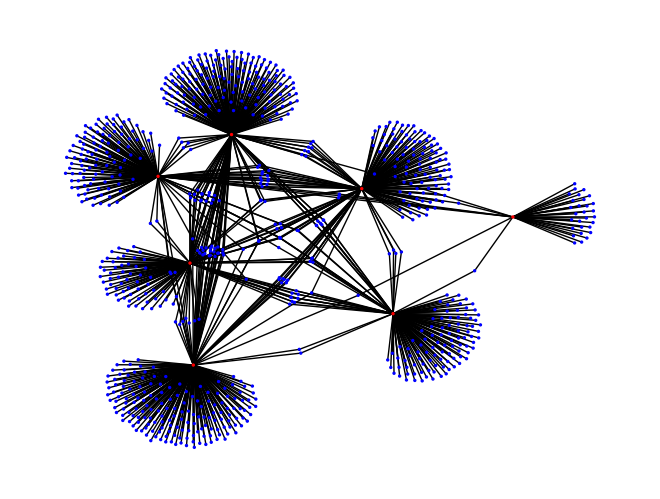

In [89]:
def visualize_graph(df, col1='STITCH', col2='Individual Side Effect', n=1000):
    poi = df_ds[[col1, col2]].head(n)
    Gp = nx.Graph()
    Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
    nx.draw(Gp, node_size=2, node_color= ['red' if node.startswith('CID') else 'blue' for node in Gp.nodes])

visualize_graph(df_ds, n=1000)

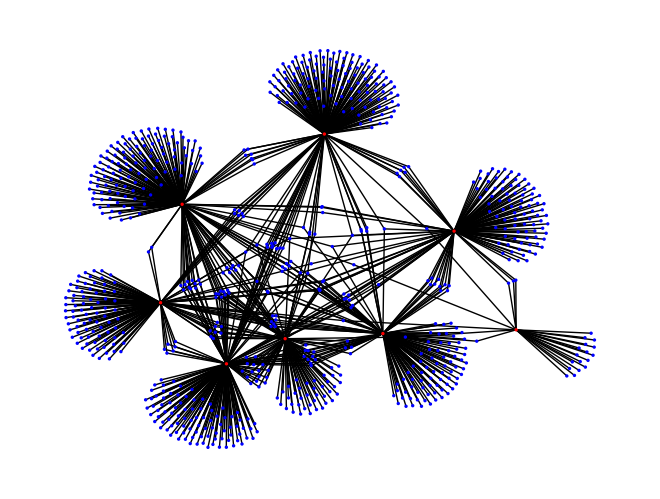

In [148]:
visualize_graph(df_ds_ft, n=1000)